In [1]:
# | default_exp ce_method
import jax

jax.config.update("jax_enable_x64", True)

In [2]:
# | export
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrn

# from isssm.typing import MarkovProcessCholeskyComponents
from jax import vmap, jit
from isssm.importance_sampling import ess_pct
from isssm.pgssm import log_prob as log_prob_joint
import tensorflow_probability.substrates.jax.distributions as tfd
from jaxtyping import Float, Array, PRNGKeyArray
from typing import Tuple
from isssm.importance_sampling import normalize_weights
from isssm.util import converged
from jax.lax import while_loop, fori_loop, scan

In [3]:
# |hide
import jax
from tensorflow_probability.substrates.jax.distributions import (
    MultivariateNormalFullCovariance as MVN,
)
import fastcore.test as fct
from isssm.pgssm import simulate_pgssm, nb_pgssm_running_example
from isssm.laplace_approximation import laplace_approximation
from isssm.importance_sampling import pgssm_importance_sampling
import matplotlib.pyplot as plt

# Cross-Entropy method 
> See also the corresponding [section in my thesis](https://stefanheyder.github.io/dissertation/thesis.pdf#nameddest=subsection.3.6.2)

The cross entropy method [@Rubinstein1997Optimization;@Rubinstein2004CrossEntropy] is a method for determining good importance sampling proposals. Given a parametric family of proposals $g_\theta(x)$ and target $p(x)$, the Cross-Entropy method aims at choosing $\theta$ such that the Cross Entropy 
$$
\mathcal H_{\text{CE}} \left( p \middle|\middle| g_{\theta} \right) = \int p(x) \log g_{\theta}(x) \mathrm d x
$$
is maximized. This is equivalent to minimizing the Kullback Leibler divergence between $p$ and $g_\theta$. As $H_\text{CE}$ is not analytically available, it is approximated by importance sampling itself, usually with a suitable proposal $g_{\hat\theta_0}$. Then the approximate optimization problem is solved, yielding $\hat \theta_1$. These steps are then iterated until convergence, using common random numbers to ensure convergence.

Considering the Cross-Entropy method with a Gaussian proposal $g_\theta$, we see that the optimal $\theta$ only depends on the first and second order moments of $p$, indeed the optimal Gaussian is the one that matches these moments. Unfortunately this approach is not feasible for the models we consider in this package as the dimensionality ($n \cdot m$) is likely too high to act on the joint distribution directly - matching means is feasible, but simulating from the distribution and evaluating the likelihood is infeasible. However, we can exploit the Markov structure of our models:

For the class of state space models treated in this package, it can be shown that the smoothing distribution, the target of our inference, $p(x|y)$, is again a Markov process, see Chapter 5 in [@Chopin2020Introduction], so it makes sense to approximate this distribution with a Gaussian Markov process.
For such a Gaussian Markov process it is known that the precision matrix $P$ of the joint distribution is sparse, indeed it is a block-tri-diagonal matrix.


## computation of Cholesky factor $L$ of $P$
[@Schafer2021Sparse] show that the centered Gaussian Markov process (more generally any Gaussian distribution with given sparsity) which minimizes the Kullback-Leibler divergence to a centered Gaussian with specified covariance matrix has an analytically and numerically tractable Cholesky decomposition that can be computed fast. Using this Cholesky decomposition we are able to evaluate the likelihood and simulate from this distribution.

Consider states $X_t$ consisting of $m$ states $X_{t,1}, \dots, X_{t, m}$. The $i$-th $v_{i}$ column of the KL-optimal Cholesky decomposition corresponding to $X_t$ can, by [@Schafer2021Sparse], be obtained by 
$$
v_{i} = \frac{1}{\lambda_{i}}\text{Cov} \left(X_{t,i}, \dots, X_{t,m}, X_{t+1, 1}, \dots, X_{t+1, m} \right)^{-1} e_{1}
$$
where $\lambda_i$ is the square root of the first entry of the matrix vector product on the right-hand side and $e_{1}$ is the first unit vector. If $t=n$, then it suffices to replace above covariance with $\text{Cov}\left(X_{t,i}, \dots, X_{t,m}\right)$. In our setup we replace the exact covariance by an importance sampling estimate with weights $w^i$, $i = 1, \dots, n$.

In [4]:
# | export
def transition_precision_root(cov):
    def _iter(carry, input):
        (ei,) = input
        i, cov = carry

        v = jnp.linalg.solve(cov, ei)
        # as jitting only works when shapes are constant
        # instead of submatrices with changing shapes, we replace
        # entries of cov succesively with identity matrix,
        # then, solving for ei is equvalent to soliving the i x i submatrix for e1
        cov = cov.at[:, i].set(ei).at[i, :].set(ei)
        return (i + 1, cov), v

    l, _ = cov.shape
    m = int(l / 2)
    _, LT = scan(_iter, (0, cov), (jnp.eye(2 * m)[:m],))
    L = LT.T

    lam = jnp.sqrt(jnp.diag(L))
    L = L / lam[None]

    return L


def final_precision_root(cov):
    def _iter(carry, input):
        (ei,) = input
        i, cov = carry

        v = jnp.linalg.solve(cov, ei)
        # same trick as for transition_precision_root
        cov = cov.at[:, i].set(ei).at[i, :].set(ei)
        return (i + 1, cov), v

    m, _ = cov.shape
    _, LT = scan(_iter, (0, cov), (jnp.eye(m),))

    lam = jnp.sqrt(jnp.diag(LT))
    L = LT.T / lam[None]
    return L


def ce_cholesky_block(
    x: Float[Array, "N m"],  # samples of $X_t$
    x_next: Float[Array, "N m"],  # samples of $X_{t+1}$
    weights: Float[Array, "N"],  # $w$, need not be normalized
) -> Float[Array, "2*m m"]:  # Cholesky factor
    """Calculate the columns and section of rows of the Cholesky factor of $P$ corresponding to $X_t$, $t < n$."""

    joint_x = jnp.concatenate([x, x_next], axis=1)
    weights = weights / weights.sum()

    # joint_mean = jnp.sum(joint_x * weights[:, None], axis=0)
    # cov = jnp.atleast_2d(
    #    jnp.sum(
    #        (joint_x[:, :, None] @ joint_x[:, None, :]) * weights[:, None, None], axis=0
    #    )
    #    - joint_mean[:, None] @ joint_mean[None, :]
    # )
    cov = jnp.atleast_2d(jnp.cov(joint_x, aweights=weights, rowvar=False))

    return transition_precision_root(cov)


def ce_cholesky_last(
    x: Float[Array, "N m"],  # samples of $X_n$
    weights: Float[Array, "N"],  # $w$, need not be normalized
) -> Float[Array, "m m"]:  # Cholesky factor
    """Calculate the Cholesky factor of $P$ corresponding to $X_n$."""
    _, m = x.shape
    weights = weights / weights.sum()

    # mean = jnp.sum(x * weights[:, None], axis=0)

    # cov = jnp.atleast_2d(
    #    jnp.sum((x[:, :, None] @ x[:, None, :]) * weights[:, None, None])
    #    - mean @ mean.T
    # )
    cov = jnp.atleast_2d(jnp.cov(x, aweights=weights, rowvar=False))

    return final_precision_root(cov)


def cholesky_components(
    samples: Float[Array, "N n m"],  # samples of $X_1, \ldots, X_n$
    weights: Float[Array, "N"],  # $w$, need not be normalized
):  # block diagonal and off-diagonal components
    """calculate all components of the Cholesky factor of $P$"""
    current = samples[:, :-1]
    next = samples[:, 1:]

    diag, off_diag = jnp.split(
        vmap(ce_cholesky_block, (1, 1, None))(current, next, weights), 2, 1
    )
    last_diag = ce_cholesky_last(samples[:, -1], weights)
    full_diag = jnp.concatenate([diag, last_diag[None, :]], axis=0)

    return (full_diag, off_diag)

## running example: AR(1) process

we'll use the simples non-degenerate Gaussian Markov process as an example, an AR(1) process. We start this process in its stationary distribution.

In [5]:
a = 1 / 2
s2 = 1.0

n = 10
# stationary
tau2 = s2 / (1 - a**2)

cov = jnp.array([[tau2 * a ** (jnp.abs(i - j)) for j in range(n)] for i in range(n)])

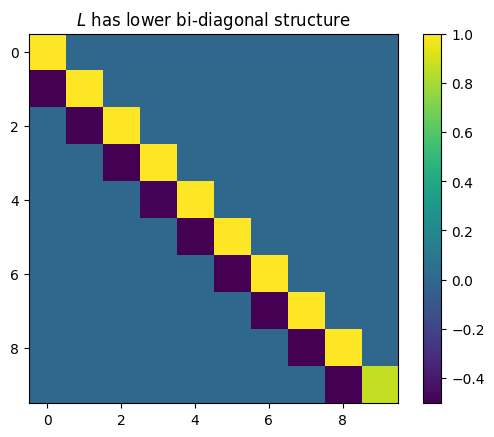

In [6]:
N = 100000
initial_samples = MVN(jnp.zeros(n), cov).sample((N,), seed=jrn.PRNGKey(5324523423))[
    ..., None
]
initial_weights = jnp.ones(N)
initial_samples.shape

root_diag, root_off_diag = cholesky_components(initial_samples, initial_weights)
P = jnp.linalg.inv(cov)
L = jnp.diag(jnp.concatenate(root_diag)[:, 0]) + jnp.diag(
    jnp.concatenate(root_off_diag)[:, 0], -1
)
plt.title("$L$ has lower bi-diagonal structure")
plt.imshow(L)
plt.colorbar()
plt.show()

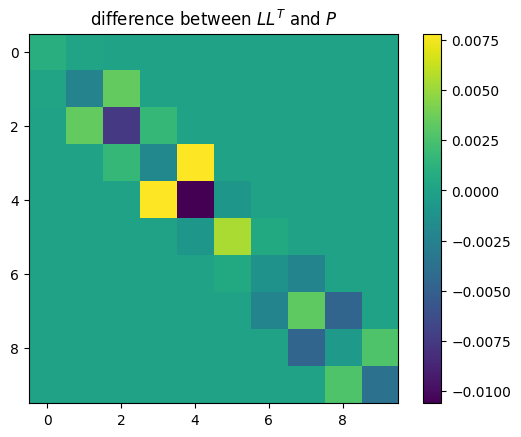

In [7]:
plt.title("difference between $L L^T$ and $P$")
plt.imshow(L @ L.T - P)
plt.colorbar()
plt.show()

In [8]:
# | hide
fct.test_close(L @ L.T, P, 0.05)

## simulation using $L$

As $LL^T = P = \Sigma^{-1}$, $L^{-T}L^{-1} = \Sigma$ so to simulate $X \sim \mathcal N(0, \Sigma)$ it suffices to simulate a standard normal $Z \sim \mathcal N(0, I)$ and solve $L^T X = Z$. Luckily, $L^T$ is an upper block diagonal matrix which solving this system of equations straightforward. To this end we partition $X = (X_1^{T}, \dots, X_n^{T})^{T}$ and $Z = (Z_1^{T}, \dots, Z_n^{T})^{T}$ and $L = \text{block-diag} \left( L_{1,1}, \dots, L_{n,n} \right) + \text{lower-block-off-diag} \left( L_{2,1}, \dots, L_{n, n-1} \right)$. Starting with $X_n$, we solve
$$
L_{n,n}^T X_{n} = Z_{n}
$$
by using the fact that $L_{n,n}^T$ is an upper triangular matrix. We then iteratively solve for $i = n-1, \dots, 1$
$$
L_{i,i}^TX_{i} + L_{i+1,i}^T X_{i + 1} = Z_{i},
$$
so
$$
X_{i} = L_{i,i}^{-T} \left( Z_{i} - L_{i +1, i}^{T} X_{i + 1} \right).
$$

In [9]:
# | export
vsolve_t = vmap(jsp.linalg.solve_triangular, (None, 0))
vmm = vmap(jnp.matmul, (None, 0))


def simulate_backwards(z_t, x_next, diag_tt, off_diag_t_tp1):
    return jsp.linalg.solve_triangular(diag_tt.T, z_t - off_diag_t_tp1 @ x_next)


def simulate(
    full_diag: Float[Array, "n m m"],  # block diagonals of $L$
    off_diag: Float[Array, "n-1 m m"],  # off-diagonals of $L$
    key: PRNGKeyArray,  # random key
    N: int,  # number of samples
) -> Float[Array, "N n m"]:  # $N$ samples of $X_1, \ldots, X_n$
    """Simulate from Markov process with Cholesky factor $L$."""
    n, m, _ = full_diag.shape

    vsimulate_backwards = vmap(simulate_backwards, (0, 0, None, None))

    def _iteration(carry, input):
        (x,) = carry
        z, full_diag, off_diag = input

        # new_x = vsolve_t(full_diag.T, z - vmm(off_diag, x))
        new_x = vsimulate_backwards(z, x, full_diag, off_diag)

        return (new_x,), new_x

    key, subkey = jrn.split(key)
    extended_off_diag = jnp.concatenate([off_diag, jnp.zeros((1, m, m))], axis=0)
    _, x = scan(
        _iteration,
        (jnp.zeros((N, m)),),
        (jrn.normal(subkey, shape=(n, N, m)), full_diag[::-1], extended_off_diag[::-1]),
    )

    x = x[::-1].transpose((1, 0, 2))

    return x

## marginal distributions

Rewriting the above equations used for simulation, we see that

$$
X_{i} = A_{i + 1} X_{i + 1} + \varepsilon_{i}
$$

with $X_n \sim \mathcal N\left(0, L_{n,n}^{-T}L_{n,n}^{-1}\right)$, $A_{i + 1} = -L_{i,i}^{-T}L_{i +1, i}^{T}$ and $\varepsilon_{i} \sim \mathcal N\left(0, L_{i,i}^{-T}L_{i,i}^{-1}\right).$

From these recursions we can caluclate the marginal covariances of $X_i$ for all $i$ by iteration.

In [10]:
# | export
def marginals(
    mu: Float[Array, "m"],  # mean
    full_diag: Float[Array, "n m m"],  # block diagonals of $L$
    off_diag: Float[Array, "n-1 m m"],  # off-diagonals of $L$
):
    n, m, _ = full_diag.shape

    Sigma = jnp.zeros((n, m, m))
    P_n = full_diag[-1].T @ full_diag[-1]
    Sigma = Sigma.at[-1].set(jnp.linalg.inv(P_n))

    for i in reversed(range(n - 1)):
        A_i = -jsp.linalg.solve_triangular(full_diag[i].T, off_diag[i].T)
        Omega_i = jnp.linalg.inv(full_diag[i].T @ full_diag[i])

        Sigma = Sigma.at[i].set(A_i.T @ Sigma[i + 1] @ A_i + Omega_i)

    return mu, vmap(jnp.diag)(Sigma)

In [11]:
L_true = jnp.linalg.cholesky(jnp.linalg.inv(cov)).T

_, marginal_var = marginals(jnp.zeros(n), root_diag, root_off_diag)

fct.test_close(marginal_var[0, 0], jnp.diag(cov), 0.01)

## Evaluating the density

Similar to simulation, we can evaluate the log-density 
$$
\log p(x) = - \frac{n\cdot m}{2}  \log(2  \pi) - \frac{1}{2} \log \det \Sigma - \frac 1 2 (x - \mu)^{T} \Sigma^{-1}(x-\mu)
$$
efficiently using $L$.

For the $\log\det \Sigma$-term notice that $\Sigma = L^{-T}L^{-1}$ results in $2 \log\det L = 2 \sum_{i = 1}^n \log\det L_{i,i}$. These determinants are simply the product of the diagonal entries, as $L$ is a lower triangular matrix.

The quadratic part can be rewritten as $\lVert L^T(x-\mu) \rVert^{2}$ and, using the structure of $L^{T}$, this consists of terms of the form $L^T_{i,i} (x_i - \mu_i) + L^T_{i+1, i}(x_{i + 1} - \mu_{i + 1})$.

In [12]:
# | export
def log_prob(
    x: Float[Array, "n+1 m"],  # the location at which to evaluate the likelihood
    full_diag: Float[Array, "n+1 m m"],  # block diagonals of $L$
    off_diag: Float[Array, "n m m"],  # off-diagonals of $L$
    mean: Float[Array, "n+1 m"],  # mean of the process
) -> Float:  # log-likelihood
    np1, m = x.shape

    # append zeros to have the same shape as full_diag
    extended_off_diag = jnp.concatenate([off_diag, jnp.zeros((m, m))[None]], axis=0)
    centered = x - mean

    # L is triangular
    logdet = 2 * jnp.sum(jnp.log(vmap(jnp.diag)(full_diag)))

    # exploit sparsity of L
    extended_centered = jnp.concatenate([centered, jnp.zeros((1, m))], axis=0)
    Lt_x = (
        full_diag.transpose((0, 2, 1)) @ extended_centered[:-1, :, None]
        + extended_off_diag.transpose((0, 2, 1)) @ extended_centered[1:, :, None]
    )[:, :, 0]
    l2_norm = jnp.sum(Lt_x**2)

    return -np1 * m / 2 * jnp.log(2 * jnp.pi) - 1 / 2 * logdet - 1 / 2 * l2_norm

In [13]:
# | hide
# log-det part
actual = log_prob(
    jnp.zeros((10, 1)), jnp.ones((10, 1, 1)), jnp.ones((9, 1, 1)), jnp.zeros((10, 1))
)
expected = -10 / 2 * jnp.log(2 * jnp.pi)
fct.test_close(actual, expected)
# l2 norm part
actual = log_prob(
    jnp.ones((10, 1)), jnp.ones((10, 1, 1)), jnp.ones((9, 1, 1)), jnp.zeros((10, 1))
)
expected = -10 / 2 * jnp.log(2 * jnp.pi) - 1 / 2 * (9 * 4 + 1)
fct.test_close(actual, expected)

In [14]:
# | hide
def kl_optimal_rev_time_markov_process(samples):
    N, n, m = samples.shape
    current = samples[:, :-1]
    next = samples[:, 1:]

    diag, off_diag = jnp.split(vmap(ce_cholesky_block, (1, 1))(current, next), 2, 1)
    last_diag = ce_cholesky_last(samples[:, -1])
    full_diag = jnp.concatenate([diag, last_diag[None, :]], axis=0)

    long_eye = jnp.tile(jnp.eye(m), (n, 1, 1))
    innov_chol = jsp.linalg.solve_triangular(
        full_diag.transpose((0, 2, 1)), long_eye, lower=False
    )
    reverse_transitions = -innov_chol[:-1] @ jnp.linalg.solve(
        off_diag.transpose((0, 2, 1)), long_eye[:-1]
    )

    return innov_chol, reverse_transitions

## Importance Sampling

For importance sampling with this model the log weights read 
$$
\log w(x) = \log p(x|y) - \log g(x) = \log p(x,y) - \log g(x) - \log p(y),
$$
where we ignore the $\log p(y)$ term to obtain autonormailsed importance sampling weights.


In [15]:
# | export
from isssm.typing import PGSSM


def ce_log_weights(
    x: Float[Array, "n+1 m"],  # the sample
    y: Float[Array, "n+1 p"],  # the observations
    full_diag: Float[Array, "n+1 m m"],  # block diagonals of $L$
    off_diag: Float[Array, "n m m"],  # off-diagonals of $L$
    mean: Float[Array, "n+1 m"],  # mean of the process
    model: PGSSM,
) -> Float:  # log-weights
    log_p = log_prob_joint(x, y, model)
    log_g = log_prob(x, full_diag, off_diag, mean)

    return log_p - log_g

## SSM to Markov Model

To inititialize the Cross-Entropy method, we will use the Laplace approximation, see [30_laplace_approximation.ipynb]. This approximates the true posterior by the posterior of a Gaussian state space model. To initiailze the Cross-entropy procedure, we determine the Cholesky root of this Gaussian posterior and use it as an initial value. To determine the diagonal and off-diagonal components of the Cholesky root, we calcultae the joint covariance matrix $\text{Cov} \left( X_t, X_{t + 1} | Y_1, \dots, Y_n \right)$ using the Kalman smoother and the FFBS, which results in 
$$
\text{Cov} \left( X_t, X_{t + 1} | Y_1, \dots, Y_n \right) = \begin{pmatrix} 
\Xi_{t|n} & \Xi_{t|t} A_t^T \Xi_{t + 1|t}^{-1} \Xi_{t + 1|n} \\
\left(\Xi_{t|t} A_t^T \Xi_{t + 1|t}^{-1} \Xi_{t + 1|n} \right)^T & \Xi_{t + 1 | n}
\end{pmatrix}.
$$

Then the algorithm by [@Schafer2021Sparse] allows us efficiently determine the desired cholesky root.

In [16]:
# | export
from jax.lax import cond
from isssm.typing import GLSSM

from isssm.kalman import kalman, smoother


def joint_cov(Xi_smooth_t, Xi_smooth_tp1, Xi_filt_t, Xi_pred_tp1, A_t):
    """Joint covariance of conditional Markov process"""
    off_diag = Xi_filt_t @ A_t.T @ jnp.linalg.solve(Xi_pred_tp1, Xi_smooth_tp1)
    return jnp.block([[Xi_smooth_t, off_diag], [off_diag.T, Xi_smooth_tp1]])


def forward_model_markov_process(y, model: GLSSM, time_reverse=True):
    """mean + Cholesky root components of precision matrix of smoothing distribution"""

    x0 = model.u[0]
    A = model.A

    filtered = kalman(y, model)
    x_filter, Xi_filter, x_pred, Xi_pred = filtered
    x_smooth, Xi_smooth = smoother(filtered, A)

    (m,) = x0.shape

    # permute X_t and X_t+1
    P = jnp.block([[jnp.zeros((m, m)), jnp.eye(m)], [jnp.eye(m), jnp.zeros((m, m))]])

    covs = vmap(joint_cov)(
        Xi_smooth[:-1], Xi_smooth[1:], Xi_filter[:-1], Xi_pred[1:], A
    )

    def forwards(x_smooth, covs, Xi_smooth):
        return x_smooth[::-1], vmap(lambda cov: P @ cov @ P.T)(covs)[::-1], Xi_smooth[0]

    def backwards(x_smooth, covs, Xi_smooth):
        return x_smooth, covs, Xi_smooth[-1]

    mu, covs, final_cov = cond(
        time_reverse, backwards, forwards, x_smooth, covs, Xi_smooth
    )

    roots = vmap(transition_precision_root)(covs)

    root_diag, root_off_diag = jnp.split(roots, 2, 1)
    final_root = final_precision_root(final_cov)

    full_diag = jnp.concatenate([root_diag, final_root[None, :]], axis=0)

    return mu, (full_diag, root_off_diag)

In [17]:
# | hide
from isssm.kalman import FFBS
from isssm.typing import GLSSM
from isssm.models.glssm import ar1

In [30]:
# | hide
glssm_model = ar1(0.0, 1, 0.5, 10, 10)
y = jnp.zeros((11, 1))
mu, (full_diag, root_off_diag) = forward_model_markov_process(y, glssm_model)

N = int(1e7)
samples = FFBS(y, glssm_model, N, jrn.PRNGKey(1345))

full_cov = jnp.cov(samples[:, :, 0], rowvar=False)
sim_L = jnp.linalg.cholesky(jnp.linalg.inv(full_cov))
sim_full_diag = jnp.diag(sim_L)
sim_off_diag = jnp.diag(sim_L, -1)

fct.test_close(sim_full_diag, full_diag[:, 0, 0], 1e-3)
fct.test_close(sim_off_diag, root_off_diag[:, 0, 0], 1e-3)

TypeError: scan body function carry input and carry output must have equal types, but they differ:

The input carry component carry[0] has type float64[1] but the corresponding output carry component has type float64[1,1], so the shapes do not match.

Revise the function so that all output types match the corresponding input types.

(1, 1)

In [ ]:
# | export


def ce_cholesky_precision(
    y: Float[Array, "n+1 p"],  # observations
    model: PGSSM,  # the model
    initial_mean: Float[Array, "n+1 m"],  # initial mean
    initial_diag: Float[Array, "n+1 m m"],  # initial off_diag
    initial_off_diag: Float[Array, "n m m"],  # initial off_diag
    n_iter: int,  # number of iterations
    N: int,  # number of samples
    key: PRNGKeyArray,  # random key
    eps: Float = 1e-5,  # convergence threshold
):
    key, subkey = jrn.split(key)
    x0, A, Sigma, B, dist, xi = model

    def _break(val):
        i, diag, off_diag, mean, old_diag, old_off_diag, old_mean = val

        diag_converged = converged(diag, old_diag, eps)
        off_diag_converged = converged(off_diag, old_off_diag, eps)
        mean_converged = converged(mean, old_mean, eps)

        all_converged = jnp.logical_and(
            diag_converged, jnp.logical_and(off_diag_converged, mean_converged)
        )

        is_first_iteration = i == 0
        iteration_limit_reached = i >= n_iter

        return jnp.logical_and(
            jnp.logical_not(is_first_iteration),
            jnp.logical_or(
                all_converged,
                iteration_limit_reached,
            ),
        )

    def _iteration(val):
        i, diag, off_diag, mean, _, _, _ = val

        samples = simulate(diag, off_diag, subkey, N) + mean

        log_weights = vmap(ce_log_weights, (0, *(None,) * 5))(
            samples, y, diag, off_diag, mean, model
        )

        weights = normalize_weights(log_weights)
        new_diag, new_off_diag = cholesky_components(samples, weights)
        new_mean = jnp.sum(samples * weights[:, None, None], axis=0)

        return i + 1, new_diag, new_off_diag, new_mean, diag, off_diag, mean

    init = _iteration(
        (
            0,
            initial_diag,
            initial_off_diag,
            initial_mean,
            initial_diag,
            initial_off_diag,
            initial_mean,
        )
    )

    _keep_going = lambda x: jnp.logical_not(_break(x))
    iterations, diag, off_diag, mean, *_ = while_loop(_keep_going, _iteration, init)

    samples = simulate(diag, off_diag, subkey, N) + mean

    log_weights = vmap(ce_log_weights, (0, *(None,) * 5))(
        samples, y, diag, off_diag, mean, model
    )

    return (diag, off_diag, mean), (samples, log_weights), iterations

In [ ]:
model = nb_pgssm_running_example()

# simulate from model
key = jrn.PRNGKey(51)
key, subkey = jrn.split(key)
N = 1
(x_true,), (y,) = simulate_pgssm(model, N, subkey)

# laplace approximation & importance sampling
s_init = jnp.log(y + 1.0)
x_smooth, z, Omega = laplace_approximation(y, model, s_init, 100)

la_glssm = GLSSM(model.x0, model.A, model.Sigma, model.B, Omega)

In [ ]:
N = 100000
key, subkey = jrn.split(key)
initial_samples, initial_log_weights = pgssm_importance_sampling(
    y, model, z, Omega, N, subkey
)

initial_weights = jnp.exp(initial_log_weights - jnp.max(initial_log_weights))
ess_pct(initial_log_weights)

In [ ]:
initial_mean, (initial_diag, initial_off_diag) = forward_model_markov_process(
    z, la_glssm
)

key, subkey = jrn.split(key)

components, (samples, log_weights), iterations = ce_cholesky_precision(
    y, model, initial_mean, initial_diag, initial_off_diag, 10, N, subkey
)

ess_pct(log_weights)

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()